In [2]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
# describe without scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df = pd.read_parquet('data/yellow/yellow_tripdata_2022-01.parquet')
df_yellow = pd.read_parquet('data/yellow/yellow_tripdata_2022-02.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [5]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
# convert to minutes
df['duration'] = df['duration'].dt.total_seconds() / 60

In [7]:
df['duration'].describe(percentiles=[0.95, 0.98, 0.99])

count   2463931.00
mean         14.21
std          46.45
min       -3442.40
50%          10.18
95%          31.93
98%          42.15
99%          50.85
max        8513.18
Name: duration, dtype: float64

## Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [8]:
((df['duration'] >= 1) & (df['duration'] <= 60)).mean()

0.9827547930522406

In [9]:
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [11]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [12]:
df[categorical] = df[categorical].astype('str')

In [13]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [14]:
train_dicts = df[categorical].to_dict(orient='records')

## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?

In [15]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [16]:
X_train
# What's the dimensionality of this matrix (number of columns)?
X_train.shape[1]

515

In [17]:
target = 'duration'
y_train = df[target].values

In [18]:
y_train

array([17.81666667,  8.4       ,  8.96666667, ..., 11.        ,
       12.05      , 27.        ])

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = lr.predict(X_train)

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

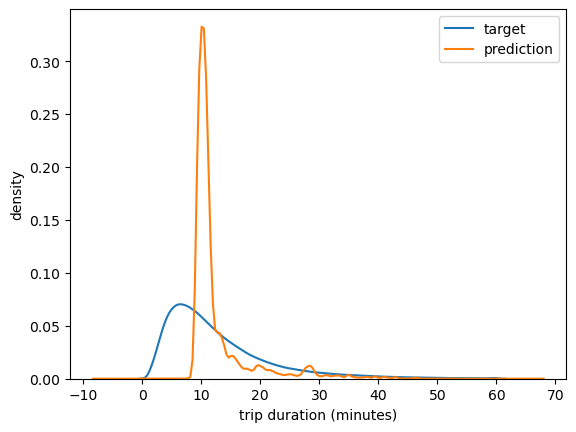

In [25]:
# density plot comparing the distribution of y_train and y_pred
sns.kdeplot(y_train, label='target')
sns.kdeplot(y_pred, label='prediction')
plt.legend()
plt.xlabel('trip duration (minutes)')
plt.ylabel('density')
plt.show()

In [24]:
mean_squared_error(y_train, y_pred, squared=False)

6.98619083458946

In [26]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    # convert to minutes
    df['duration'] = df['duration'].dt.total_seconds() / 60

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype('str')
    return df

In [30]:
df_train = read_dataframe('data/yellow/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('data/yellow/yellow_tripdata_2022-02.parquet')

In [31]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [34]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.78640785205543